# GOES ABI, MODIS, ASTER Comparison
## Compute summary statistics for their ~11 micron TIR bands

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import xarray as xr
import os
import glob

# for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

# for plotting ASTER geotiffs
import rasterio as rio
import rasterio.plot as rioplt
from rasterio.warp import calculate_default_transform

# for working with raster data
import rioxarray

# for shapefile
import geopandas as gpd

# for MODIS conversions
import modis_utils

# for calculating zonal statistics
import aster_utils

# for GOES
import goes_utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

Set font sizes for plots

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Define some funcitons I'll use below

In [4]:
# use this function to match the date/time of observations
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

---
### Find GOES ABI, MODIS, and ASTER image triplets

Get filepaths for ASTER images

In [5]:
aster_directory = "/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/"
# Find all our ASTER files and their timestamps in our directory
df = aster_utils.aster_timestamps(aster_directory, ext='tif')
# add a UTC-8 datetime for pacific standard that CUES uses
df['datetime'] = df.timestampUTC - pd.Timedelta(hours=8)
# save a csv file of the ASTER files we are using
#aster.to_csv('aster_AST_L1T_band14_Tuolumne-and-CUES.csv')

Get filepaths for orthorectified GOES brightness temperature, radiance images and "zone_labels"

In [6]:
goes_directory = "/storage/GOES/orthorectified"
ortho_goes_tb_filelist = glob.glob(goes_directory + '/**/*_orthorectified_tb.tif', recursive=True)
ortho_goes_rad_filelist = glob.glob(goes_directory + '/**/*_orthorectified_Rad.tif', recursive=True)
ortho_goes_zones_filelist = glob.glob(goes_directory + '/**/*_orthorectified_zone_labels.tif', recursive=True)

Find the GOES Brightness Temperature observations at the same time as ASTER

In [7]:
goes_tb_dict = goes_utils.goes_timestamps(ortho_goes_tb_filelist)

Find the GOES Radiance observations at the same time as ASTER

In [8]:
goes_rad_dict = goes_utils.goes_timestamps(ortho_goes_rad_filelist)

Find the GOES "zone_labels" files at the same time as ASTER

In [9]:
goes_zones_dict = goes_utils.goes_timestamps(ortho_goes_zones_filelist)

Match GOES ABI images with corresponding ASTER image

In [10]:
df['goes_timestampUTC'] = df.timestampUTC
df['goes_tb_filepath'] = df.filepath
df['goes_rad_filepath'] = df.filepath
df['goes_zones_filepath'] = df.filepath

for i in range(len(df)):
    nearest_goes_timestampUTC = nearest(list(goes_rad_dict.keys()), df.timestampUTC[i])
    #print('ASTER: {}\nGOES: {}\n\n'.format(df.timestampUTC[i], nearest_goes_timestampUTC))
    df['goes_timestampUTC'][i] = nearest_goes_timestampUTC
    df['goes_rad_filepath'][i] = goes_rad_dict[nearest_goes_timestampUTC]['filepath']
    nearest_goes_tb_timestampUTC = nearest(list(goes_tb_dict.keys()), df.timestampUTC[i])
    df['goes_tb_filepath'][i] = goes_tb_dict[nearest_goes_tb_timestampUTC]['filepath']
    nearest_goes_zone_timestampUTC = nearest(list(goes_zones_dict.keys()), df.timestampUTC[i])
    df['goes_zones_filepath'][i] = goes_zones_dict[nearest_goes_zone_timestampUTC]['filepath']

# make anoter column of UTC-8 (PST) times:
df['goes_timestampPST'] = df.goes_timestampUTC - pd.Timedelta(hours=8)


Get filepaths for the MODIS observations I've created NetCDF files for, and their corresponding timestamps:

In [11]:
# search for MODIS files in this directory
modis_dir = '/storage/MODIS/Tuolumne_MOD021KM/'
# get .tif files here
modis_filelist = glob.glob(modis_dir + '*.tif', recursive=True)

# create an empty dictionary we'll fill with filenames and timestamps for each modis image we have
modis_dict = {}

for this_modis_file in modis_filelist:
    # get just the filename
    this_modis_filename = os.path.normpath(this_modis_file).split('/')[-1]
    # then parse the year, day of year, hour, and minutes from the filename
    this_modis_date_time = this_modis_filename.split('.')[1] + this_modis_filename.split('.')[2]
    this_modis_timestampUTC = pd.to_datetime(this_modis_date_time[1:], format="%Y%j%H%M")
    this_modis_timestampUTC = pd.Timestamp(this_modis_timestampUTC, tz='UTC') #also specify UTC
    # add these to our dictionary, use the date as the key
    modis_dict[this_modis_timestampUTC] = {}
    modis_dict[this_modis_timestampUTC]['filepath'] = this_modis_file

Match ASTER with it's corresponding MODIS image:

In [12]:
df['modis_timestampUTC'] = df.timestampUTC
df['modis_filepath'] = df.filepath

for i in range(len(df)):
    nearest_modis_timestampUTC = nearest(list(modis_dict.keys()), df.timestampUTC[i])
    #print('ASTER: {}\nMODIS: {}\n\n'.format(df.timestampUTC[i], nearest_modis_timestampUTC))
    df['modis_timestampUTC'][i] = nearest_modis_timestampUTC
    df['modis_filepath'][i] = modis_dict[nearest_modis_timestampUTC]['filepath']
    
# make anoter column for MODIS UTC-8 (PST) times:
df['modis_timestampPST'] = df.modis_timestampUTC - pd.Timedelta(hours=8)



In [13]:
# preview dataframe
df.head(3)

,timestampUTC,filepath,datetime,goes_timestampUTC,goes_tb_filepath,goes_rad_filepath,goes_zones_filepath,goes_timestampPST,modis_timestampUTC,modis_filepath,modis_timestampPST
0,2017-03-04 18:51:03+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-03-04 10:51:03+00:00,2017-03-04 18:50:28+00:00,/storage/GOES/orthorectified/2017/03/4/ABI-L1b...,/storage/GOES/orthorectified/2017/03/4/ABI-L1b...,/storage/GOES/orthorectified/2017/03/4/ABI-L1b...,2017-03-04 10:50:28+00:00,2017-03-04 18:50:00+00:00,/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A201...,2017-03-04 10:50:00+00:00
1,2017-03-20 18:51:06+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-03-20 10:51:06+00:00,2017-03-20 18:50:28+00:00,/storage/GOES/orthorectified/2017/03/20/ABI-L1...,/storage/GOES/orthorectified/2017/03/20/ABI-L1...,/storage/GOES/orthorectified/2017/03/20/ABI-L1...,2017-03-20 10:50:28+00:00,2017-03-20 18:50:00+00:00,/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A201...,2017-03-20 10:50:00+00:00
2,2017-04-21 18:51:07+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-04-21 10:51:07+00:00,2017-04-21 18:50:02+00:00,/storage/GOES/orthorectified/2017/04/21/ABI-L1...,/storage/GOES/orthorectified/2017/04/21/ABI-L1...,/storage/GOES/orthorectified/2017/04/21/ABI-L1...,2017-04-21 10:50:02+00:00,2017-04-21 18:50:00+00:00,/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A201...,2017-04-21 10:50:00+00:00


Save out dataframe with image triplet filepaths and timestamps to csv file:

In [14]:
df.to_csv('goes_orthorectified_tb_rad_zones-modis-aster-list.csv')

---

---

## Compute summary statistics

#### And optionally make overview plots

Define a working area to clip all three rasters to the same common area before computing summary statistics:

In [15]:
# Define a working area here in local UTM coordinates to clip all three rasters to the same common area

## Area around Tuolumne
#utm_northings_max = 4205000
#utm_northings_min = 4185000
#utm_eastings_max = 305000
#utm_eastings_min = 285000

# Larger area around Tuolumne further south and east to include Mammoth
utm_northings_max = 4205000
utm_northings_min = 4140000
utm_eastings_max = 320000
utm_eastings_min = 285000


geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_eastings_min, utm_northings_max],
            [utm_eastings_max, utm_northings_max],
            [utm_eastings_max, utm_northings_min],
            [utm_eastings_min, utm_northings_min]
        ]]
    }
]

Load image triplets, compute summary statistics:

In [24]:
# Set up file output options
output_filename_prefix = 'ASTER-MODIS-GOES_'
output_filename_suffix = '.nc'
output_dir = './data/ASTER-MODIS-GOES/'

# Make an empty list to hold all the resulting datasets
#ds_list = []


# pick one set of images from our list
for n in range(len(df)):
    print(n)
    
    # Zonal statistics between ASTER and GOES
    print('Zonal stats between ASTER and GOES\n{}\n{}'.format(df.filepath[n],df.goes_rad_filepath[n]))
    aster_goes_ds = aster_utils.upscale_aster_goes_rad_zonal_stats(aster_rad_filepath = df.filepath[n], 
                                                                   goes_rad_filepath = df.goes_rad_filepath[n], 
                                                                   goes_zones_filepath = df.goes_zones_filepath[n],
                                                                   goes_tb_filepath = df.goes_tb_filepath[n],
                                                                   bounding_geometry=None, 
                                                                   zonal_count_threshold=None,  # 800 pixels
                                                                   output_filepath=None)
    
    # Zonal statistics between ASTER and MODIS
    print('Zonal stats between ASTER and MODIS\n{}\n{}'.format(df.filepath[n],df.modis_filepath[n]))
    aster_modis_ds = aster_utils.upscale_aster_modis_rad_zonal_stats(aster_rad_filepath = df.filepath[n],
                                                                     modis_rad_filepath = df.modis_filepath[n], 
                                                                     bounding_geometry=None, 
                                                                     modis_band_index=10, 
                                                                     zonal_count_quantile_threshold=0, 
                                                                     output_filepath=None)
    
    print('Fixing data variable and attribute names to avoid merge conflicts and invalid characters')
    # rename data variables to avoid conflict on merge
    for key in aster_goes_ds.keys():
        aster_goes_ds = aster_goes_ds.rename({key: 'ast_goes_'+key})
    for key in aster_modis_ds.keys():
        aster_modis_ds = aster_modis_ds.rename({key: 'ast_mod_'+key})
    # remove % and " " characters from attributes
    for da in aster_modis_ds:
        for attr_key in aster_modis_ds[da].attrs.keys():
            new_atr_key = attr_key.replace('%', '').replace(' ', '')
            aster_modis_ds[da].attrs[new_atr_key] = aster_modis_ds[da].attrs.pop(attr_key)
    
    # Merge both datasets
    print('Merging datasets...')
    ds = xr.merge([aster_goes_ds, aster_modis_ds])
    
    # Add time dimension
    print('Add time UTC dimension')
    ds = ds.expand_dims({'time': [ df.timestampUTC[n] ]})
    
    ## Append dataset of this image triplet to list
    ##ds_list.append(ds)
    #
    # Set up filename for output
    output_filename_timestamp = df.timestampUTC[n].strftime('%Y-%m-%dT%H%M%SUTC')
    output_filepath = output_dir + output_filename_prefix + output_filename_timestamp + output_filename_suffix
    
    print('Export to NetCDF file...')
    # export to netcdf file
    ds.to_netcdf(output_filepath)
    print('Moving onto next...')

0
Zonal stats between ASTER and GOES
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00303042017185103_20170305091359_4951_ImageData14.tif
/storage/GOES/orthorectified/2017/03/4/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M3C14_G16_s20170631847509_e20170631850282_c20170631850319_orthorectified_Rad.tif
>>>>>>>>>>>>>>>>>>>Open and clean-up input datasets
>>>>>>>>>>>>>>>>>>>Use reproject_match...
>>>>>>>>>>>>>>>>>>>clean up aster...
>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>map results from zonal stats back onto grid
>>>>>>>>>>>>>>>>>>>compute TB
>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>merge all together
>>>>>>>>>>>>>>>>>>>clip to aster image extent
>>>>>>>>>>>>>>>>>>>return dataset
Zonal stats between ASTER and MODIS
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00303042017185103_20170305091359_4951_ImageData14.tif
/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A2017063.1850.061.2017312092219.tif
>>>>>>>>>>>

>>>>>>>>>>>>>>>>>>>map results from zonal stats back onto grid
>>>>>>>>>>>>>>>>>>>compute TB
>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>merge all together
>>>>>>>>>>>>>>>>>>>clip to aster image extent
>>>>>>>>>>>>>>>>>>>return dataset
Zonal stats between ASTER and MODIS
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00306072017060719_20170608114206_30429_ImageData14.tif
/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A2017158.0605.061.2017314235847.tif
>>>>>>>>>>>>>>>>>>>>>>open and clean up aster image
>>>>>>>>>>>>>>>>>>>>>>open and reproject match MODIS image
>>>>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>>>>map results back onto grid
>>>>>>>>>>>>>>>>>>>>>>compute brightness temperature
>>>>>>>>>>>>>>>>>>>>>>merge datasets together
>>>>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>>>>return dataset
Fixing data variable and attribute names to avoid merge conflicts and invalid characters
Merging datasets...
Add time UTC di

>>>>>>>>>>>>>>>>>>>>>>open and reproject match MODIS image
>>>>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>>>>map results back onto grid
>>>>>>>>>>>>>>>>>>>>>>compute brightness temperature
>>>>>>>>>>>>>>>>>>>>>>merge datasets together
>>>>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>>>>return dataset
Fixing data variable and attribute names to avoid merge conflicts and invalid characters
Merging datasets...
Add time UTC dimension
Export to NetCDF file...
Moving onto next...
11
Zonal stats between ASTER and GOES
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00301032018055458_20180104122052_7153_ImageData14.tif
/storage/GOES/orthorectified/2018/01/3/ABI-L1b-RadC/05/C14/OR_ABI-L1b-RadC-M3C14_G16_s20180030552203_e20180030554576_c20180030555025_orthorectified_Rad.tif
>>>>>>>>>>>>>>>>>>>Open and clean-up input datasets
>>>>>>>>>>>>>>>>>>>Use reproject_match...
>>>>>>>>>>>>>>>>>>>clean up aster...
>>>>>>>>>>>>>>>>>>>compute zonal stats


Moving onto next...
16
Zonal stats between ASTER and GOES
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00306022018185839_20180603133217_19253_ImageData14.tif
/storage/GOES/orthorectified/2018/06/2/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M3C14_G16_s20181531857290_e20181531900063_c20181531900111_orthorectified_Rad.tif
>>>>>>>>>>>>>>>>>>>Open and clean-up input datasets
>>>>>>>>>>>>>>>>>>>Use reproject_match...
>>>>>>>>>>>>>>>>>>>clean up aster...
>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>map results from zonal stats back onto grid
>>>>>>>>>>>>>>>>>>>compute TB
>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>merge all together
>>>>>>>>>>>>>>>>>>>clip to aster image extent
>>>>>>>>>>>>>>>>>>>return dataset
Zonal stats between ASTER and MODIS
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00306022018185839_20180603133217_19253_ImageData14.tif
/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A2018153.1855.061.201815

>>>>>>>>>>>>>>>>>>>map results from zonal stats back onto grid
>>>>>>>>>>>>>>>>>>>compute TB
>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>merge all together
>>>>>>>>>>>>>>>>>>>clip to aster image extent
>>>>>>>>>>>>>>>>>>>return dataset
Zonal stats between ASTER and MODIS
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00311012018060755_20181102132708_19530_ImageData14.tif
/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A2018305.0605.061.2018305193436.tif
>>>>>>>>>>>>>>>>>>>>>>open and clean up aster image
>>>>>>>>>>>>>>>>>>>>>>open and reproject match MODIS image
>>>>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>>>>map results back onto grid
>>>>>>>>>>>>>>>>>>>>>>compute brightness temperature
>>>>>>>>>>>>>>>>>>>>>>merge datasets together
>>>>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>>>>return dataset
Fixing data variable and attribute names to avoid merge conflicts and invalid characters
Merging datasets...
Add time UTC di

>>>>>>>>>>>>>>>>>>>>>>open and reproject match MODIS image
>>>>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>>>>map results back onto grid
>>>>>>>>>>>>>>>>>>>>>>compute brightness temperature
>>>>>>>>>>>>>>>>>>>>>>merge datasets together
>>>>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>>>>return dataset
Fixing data variable and attribute names to avoid merge conflicts and invalid characters
Merging datasets...
Add time UTC dimension
Export to NetCDF file...
Moving onto next...
27
Zonal stats between ASTER and GOES
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00304272019185122_20190428120146_10912_ImageData14.tif
/storage/GOES/orthorectified/2019/04/27/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M6C14_G16_s20191171846206_e20191171848579_c20191171849033_orthorectified_Rad.tif
>>>>>>>>>>>>>>>>>>>Open and clean-up input datasets
>>>>>>>>>>>>>>>>>>>Use reproject_match...
>>>>>>>>>>>>>>>>>>>clean up aster...
>>>>>>>>>>>>>>>>>>>compute zonal stat

Moving onto next...
32
Zonal stats between ASTER and GOES
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00306062019060113_20190607134953_12369_ImageData14.tif
/storage/GOES/orthorectified/2019/06/6/ABI-L1b-RadC/06/C14/OR_ABI-L1b-RadC-M6C14_G16_s20191570601440_e20191570604213_c20191570604266_orthorectified_Rad.tif
>>>>>>>>>>>>>>>>>>>Open and clean-up input datasets
>>>>>>>>>>>>>>>>>>>Use reproject_match...
>>>>>>>>>>>>>>>>>>>clean up aster...
>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>map results from zonal stats back onto grid
>>>>>>>>>>>>>>>>>>>compute TB
>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>merge all together
>>>>>>>>>>>>>>>>>>>clip to aster image extent
>>>>>>>>>>>>>>>>>>>return dataset
Zonal stats between ASTER and MODIS
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00306062019060113_20190607134953_12369_ImageData14.tif
/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A2019157.0600.061.201915

>>>>>>>>>>>>>>>>>>>map results from zonal stats back onto grid
>>>>>>>>>>>>>>>>>>>compute TB
>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>merge all together
>>>>>>>>>>>>>>>>>>>clip to aster image extent
>>>>>>>>>>>>>>>>>>>return dataset
Zonal stats between ASTER and MODIS
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00307082019060101_20190709132009_19937_ImageData14.tif
/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A2019189.0600.061.2019189191229.tif
>>>>>>>>>>>>>>>>>>>>>>open and clean up aster image
>>>>>>>>>>>>>>>>>>>>>>open and reproject match MODIS image
>>>>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>>>>map results back onto grid
>>>>>>>>>>>>>>>>>>>>>>compute brightness temperature
>>>>>>>>>>>>>>>>>>>>>>merge datasets together
>>>>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>>>>return dataset
Fixing data variable and attribute names to avoid merge conflicts and invalid characters
Merging datasets...
Add time UTC di

>>>>>>>>>>>>>>>>>>>>>>open and reproject match MODIS image
>>>>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>>>>map results back onto grid
>>>>>>>>>>>>>>>>>>>>>>compute brightness temperature
>>>>>>>>>>>>>>>>>>>>>>merge datasets together
>>>>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>>>>return dataset
Fixing data variable and attribute names to avoid merge conflicts and invalid characters
Merging datasets...
Add time UTC dimension
Export to NetCDF file...
Moving onto next...
43
Zonal stats between ASTER and GOES
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00301072020060650_20200108141156_10342_ImageData14.tif
/storage/GOES/orthorectified/2020/01/7/ABI-L1b-RadC/06/C14/OR_ABI-L1b-RadC-M6C14_G16_s20200070606176_e20200070608549_c20200070609029_orthorectified_Rad.tif
>>>>>>>>>>>>>>>>>>>Open and clean-up input datasets
>>>>>>>>>>>>>>>>>>>Use reproject_match...
>>>>>>>>>>>>>>>>>>>clean up aster...
>>>>>>>>>>>>>>>>>>>compute zonal stats

Moving onto next...
48
Zonal stats between ASTER and GOES
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00302262020055525_20200227083903_9621_ImageData14.tif
/storage/GOES/orthorectified/2020/02/26/ABI-L1b-RadC/05/C14/OR_ABI-L1b-RadC-M6C14_G16_s20200570551151_e20200570553524_c20200570554065_orthorectified_Rad.tif
>>>>>>>>>>>>>>>>>>>Open and clean-up input datasets
>>>>>>>>>>>>>>>>>>>Use reproject_match...
>>>>>>>>>>>>>>>>>>>clean up aster...
>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>map results from zonal stats back onto grid
>>>>>>>>>>>>>>>>>>>compute TB
>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>merge all together
>>>>>>>>>>>>>>>>>>>clip to aster image extent
>>>>>>>>>>>>>>>>>>>return dataset
Zonal stats between ASTER and MODIS
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00302262020055525_20200227083903_9621_ImageData14.tif
/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A2020057.0555.061.2020057

>>>>>>>>>>>>>>>>>>>map results from zonal stats back onto grid
>>>>>>>>>>>>>>>>>>>compute TB
>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>merge all together
>>>>>>>>>>>>>>>>>>>clip to aster image extent
>>>>>>>>>>>>>>>>>>>return dataset
Zonal stats between ASTER and MODIS
/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00306152020060700_20200616104305_10787_ImageData14.tif
/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A2020167.0605.061.2020167221653.tif
>>>>>>>>>>>>>>>>>>>>>>open and clean up aster image
>>>>>>>>>>>>>>>>>>>>>>open and reproject match MODIS image
>>>>>>>>>>>>>>>>>>>>>>compute zonal stats
>>>>>>>>>>>>>>>>>>>>>>map results back onto grid
>>>>>>>>>>>>>>>>>>>>>>compute brightness temperature
>>>>>>>>>>>>>>>>>>>>>>merge datasets together
>>>>>>>>>>>>>>>>>>>>>>compute differences
>>>>>>>>>>>>>>>>>>>>>>return dataset
Fixing data variable and attribute names to avoid merge conflicts and invalid characters
Merging datasets...
Add time UTC di

In [25]:
ds

<xarray.Dataset>
Dimensions:                 (time: 1, x: 939, y: 834)
Coordinates:
  * time                    (time) datetime64[ns] 2020-06-17T05:54:47
  * x                       (x) float64 3.072e+05 3.073e+05 ... 3.916e+05
  * y                       (y) float64 4.213e+06 4.213e+06 ... 4.138e+06
    band                    int64 1
    spatial_ref             int64 0
    quantile                float64 0.0
Data variables:
    ast_goes_aster_rad      (time, y, x) float64 nan nan nan nan ... nan nan nan
    ast_goes_goes_rad       (time, y, x) float32 nan nan nan nan ... nan nan nan
    ast_goes_goes_tb        (time, y, x) float32 nan nan nan nan ... nan nan nan
    ast_goes_goes_zones     (time, y, x) float64 nan nan nan nan ... nan nan nan
    ast_goes_mean_rad       (time, y, x) float64 nan nan nan nan ... nan nan nan
    ast_goes_max_rad        (time, y, x) float64 nan nan nan nan ... nan nan nan
    ast_goes_min_rad        (time, y, x) float64 nan nan nan nan ... nan nan nan
   

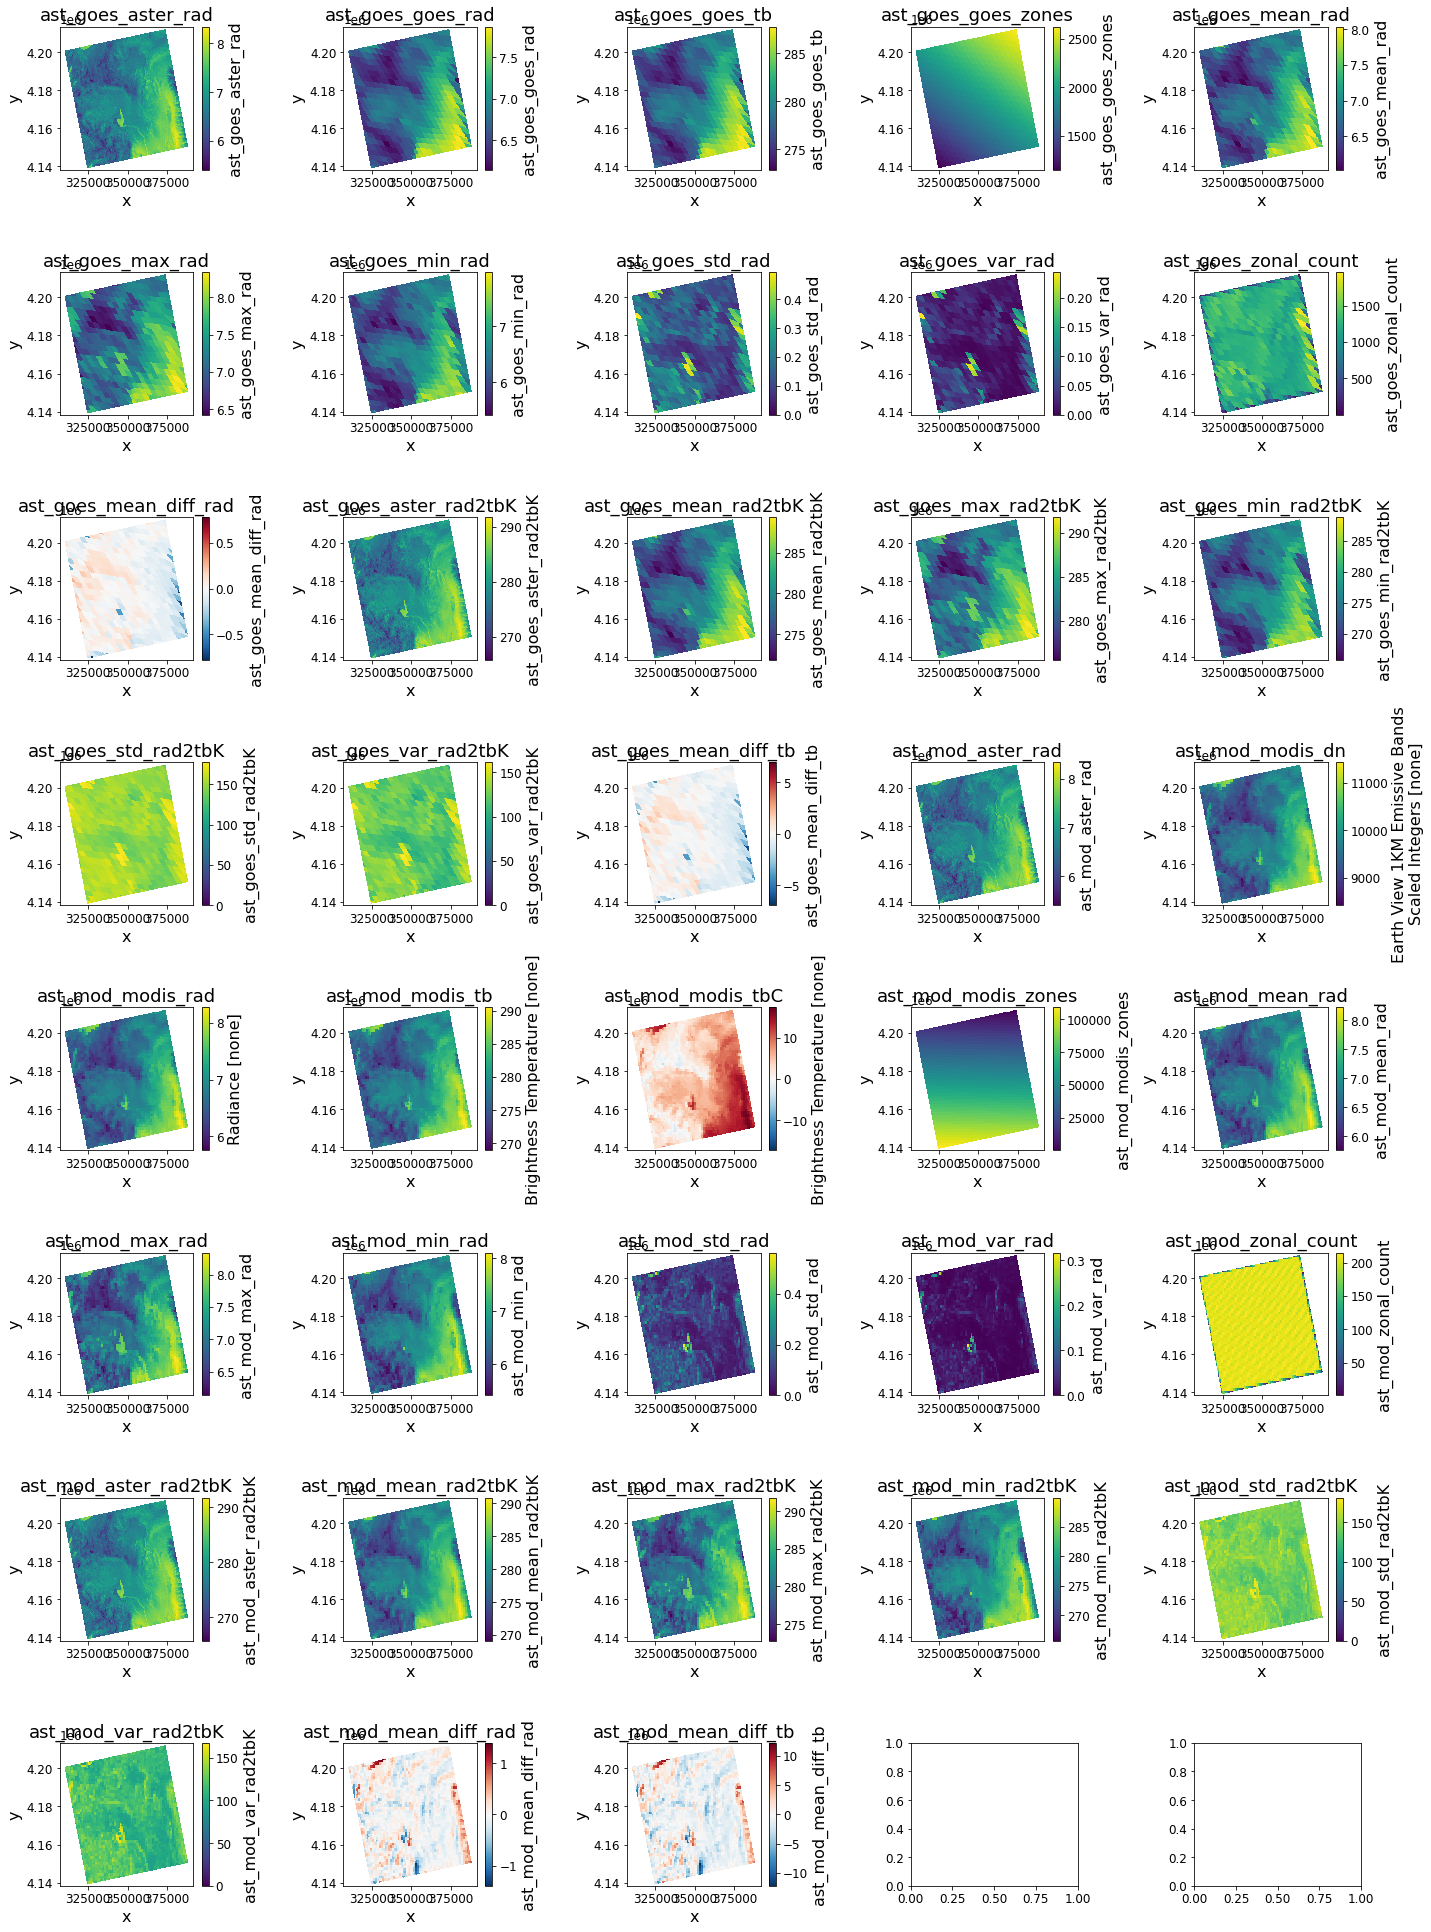

In [26]:
fig, ax = plt.subplots(nrows=8, ncols=5, figsize=(20,27), tight_layout=True)
ax = ax.flatten()

for i, data_var in enumerate(ds):
    ds[str(data_var)].plot(ax=ax[i])
    ax[i].set_title(str(data_var))